## Preprocessing


In [ ]:
import pandas as pd
import numpy as np

Mounted at /content/drive


In [ ]:
df = pd.read_csv('fake reviews dataset.csv')

df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [ ]:
df.drop(columns = {'category'}, inplace = True)

In [ ]:
df.sample(3)

,rating,label,text_
3565,5.0,OR,I bought this food processor a little over 3 y...
29049,5.0,CG,this book is important to know. The author has...
17929,1.0,CG,"I've bought 4 of these, and have been using th..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   rating  40432 non-null  float64
 1   label   40432 non-null  object 
 2   text_   40432 non-null  object 
dtypes: float64(1), object(2)
memory usage: 947.8+ KB


In [ ]:
df.rename(columns = {'text_': 'text'}, inplace = True)

In [ ]:
def encode_label(df):
    labels = {
        'CG': 0,
        'OR': 1
    }

    df['target'] = df['label'].map(labels)

    return df

In [ ]:
df = encode_label(df)
df['target'] = df['target'].fillna(0).replace([np.inf, -np.inf], 0)
df['target'] = df['target'].astype(int)
df.head()

,rating,label,text,target
0,5.0,CG,"Love this! Well made, sturdy, and very comfor...",0
1,5.0,CG,"love it, a great upgrade from the original. I...",0
2,5.0,CG,This pillow saved my back. I love the look and...,0
3,1.0,CG,"Missing information on how to use it, but it i...",0
4,5.0,CG,Very nice set. Good quality. We have had the s...,0


In [ ]:
df.drop(columns = {'rating', 'label'}, inplace = True)

In [ ]:
# Shuffle the dataset & reset index >> useful before splitting into train/val/test)

df = df.sample(frac=1).reset_index(drop=True)

df.head()

,text,target
0,"just like in Disney world but much cheaper, an...",1
1,This is a lot of time to wait for the instruct...,0
2,My wife and I love this mat and the materials....,0
3,perfect design. I redid my bathroom and have t...,1
4,I bought this for my Windows 7 Desktop PC. I ...,1


In [ ]:
df.isnull().sum()

,0
text,0
target,0


In [ ]:
df.duplicated().sum()

np.int64(20)

In [ ]:
df.drop_duplicates(inplace = True)
df.duplicated().sum()

np.int64(0)

In [ ]:
df['target'].value_counts()

,count
target,
1,20215
0,20197


In [ ]:
from sklearn.model_selection import train_test_split

# Train-validation-test split: 70-15-15
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['target'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['target'])

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

Train: 28288, Val: 6062, Test: 6062


## distilBERT

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import evaluate
import torch

In [ ]:
# Load DistilBERT tokenizer and model
checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)
print("DistilBERT loaded successfully")

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBERT loaded successfully


In [ ]:
# Prepare datasets in HuggingFace format
train_hf = pd.DataFrame({"text": train_df['text'].tolist(), "label": train_df['target'].tolist()})
val_hf = pd.DataFrame({"text": val_df['text'].tolist(), "label": val_df['target'].tolist()})
test_hf = pd.DataFrame({"text": test_df['text'].tolist(), "label": test_df['target'].tolist()})

train_dataset = Dataset.from_pandas(train_hf)
val_dataset = Dataset.from_pandas(val_hf)
test_dataset = Dataset.from_pandas(test_hf)
print("Datasets created")

Datasets created


In [ ]:
# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)

In [ ]:
# Tokenize all datasets
print("Tokenizing datasets...")
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)
print("Tokenization complete")

Tokenizing datasets...


Map:   0%|          | 0/28288 [00:00<?, ? examples/s]

Map:   0%|          | 0/6062 [00:00<?, ? examples/s]

Map:   0%|          | 0/6062 [00:00<?, ? examples/s]

Tokenization complete


In [ ]:
# Set format for PyTorch
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])
print("Datasets formatted for PyTorch")

Datasets formatted for PyTorch


In [ ]:
# Metric computation function
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = metric.compute(predictions=predictions, references=labels)

    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')

    return {
        'accuracy': accuracy['accuracy'],
        'precision': precision,
        'recall': recall,
        'f1': f1
    }


In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    logging_dir="./logs",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=100,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

In [ ]:
# Initialize Trainer
print("Initializing Trainer...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)
print("Trainer initialized")

Initializing Trainer...
Trainer initialized


/tmp/ipython-input-217685592.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Train the model
print("Starting DistilBERT training...")
trainer.train()
print("Training completed successfully")

Starting DistilBERT training...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.104600,0.088697,0.964698,0.988223,0.940653,0.963851
2,0.038600,0.084864,0.978555,0.991534,0.965381,0.978283
3,0.000200,0.131597,0.977070,0.990508,0.963403,0.976768


Training completed successf


In [ ]:
# Evaluate on test set
print("Evaluating on test set...")
eval_results = trainer.evaluate(test_dataset)

print("\n" + "="*50)
print("DISTILBERT EVALUATION RESULTS")
print("="*50)
print(f"Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"Precision: {eval_results['eval_precision']:.4f}")
print(f"Recall: {eval_results['eval_recall']:.4f}")
print(f"F1-Score: {eval_results['eval_f1']:.4f}")

Evaluating on test set...



DISTILBERT EVALUATION RESULTS
Accuracy: 0.9804
Precision: 0.9912
Recall: 0.9693
F1-Score: 0.9802


In [ ]:
# Get predictions for confusion matrix and further analysis
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

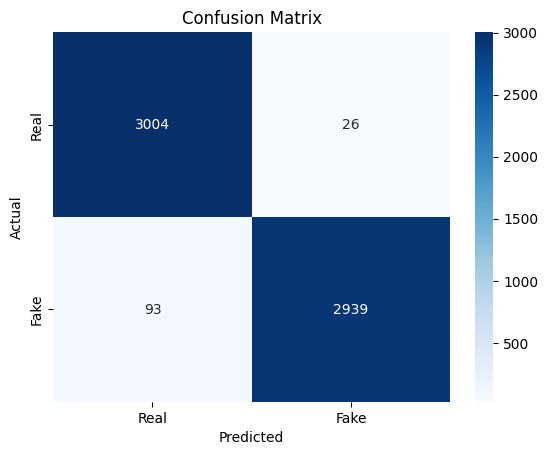

In [ ]:
#Confusion Matrix for evaluation
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_df['target'], preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_path = '/content/drive/MyDrive/Project1_all_resources/My_model'

tokenizer = AutoTokenizer.from_pretrained(model_path, local_files_only=True)
model = AutoModelForSequenceClassification.from_pretrained(model_path, local_files_only=True)